In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [113]:
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [114]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [115]:

dataset['sex'] = dataset['sex'].map({'female': 1, 'male': 2}).astype(np.int32)
dataset['smoker'] = dataset['smoker'].map({'yes': 1, 'no': 0}).astype(np.int32)
dataset['region'] = dataset['region'].astype('category').cat.codes
# 1. L'interazione critica: Se fumi, quanto pesa il tuo BMI?


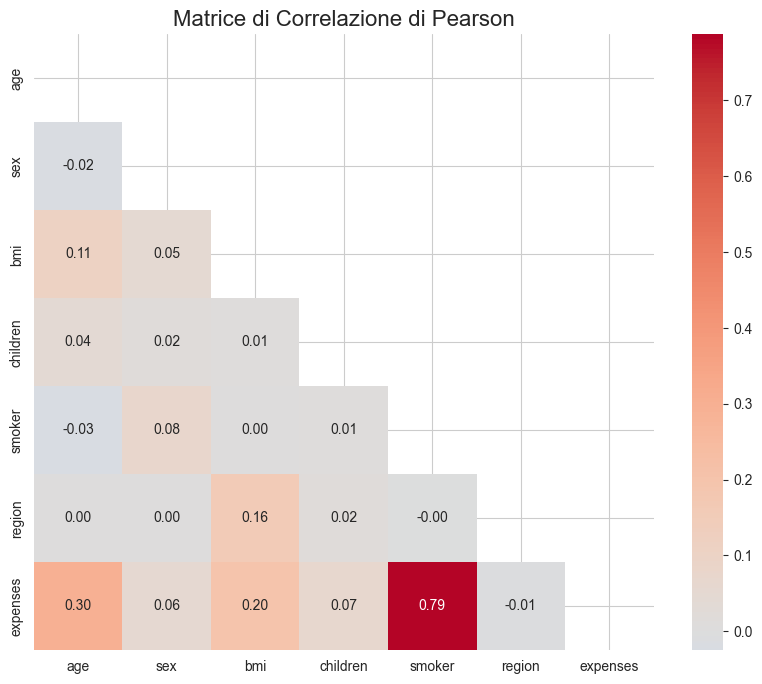

In [116]:
# Mappatura temporanea per correlazione
corr_df = dataset.copy()


plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_df.corr(), dtype=bool)) # Nasconde la parte superiore ridondante
sns.heatmap(corr_df.corr(), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione di Pearson', fontsize=16)
plt.show()

In [117]:
import plotly.express as px

# Creazione del grafico 3D interattivo
fig = px.scatter_3d(
    dataset, 
    x='age', 
    y='bmi', 
    z='smoker',
    color='expenses',          # Colore basato sulla spesa
    symbol='smoker',          # Forma diversa per fumatori/non fumatori
    opacity=0.7,
    size_max=10,
    title='Analisi Interattiva: Impatto di Età, BMI e Fumo sui Costi',
    labels={'age': 'Età', 'bmi': 'BMI', 'smoker': 'Fumatore (1=Sì)', 'expenses': 'Spesa ($)'},
    color_continuous_scale='Jet' # Scala cromatica simile a quella che avevi usato
)

# Miglioramento del layout
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis_title='Età',
        yaxis_title='BMI',
        zaxis_title='Fumo'
    )
)

fig.show()

plt.show()

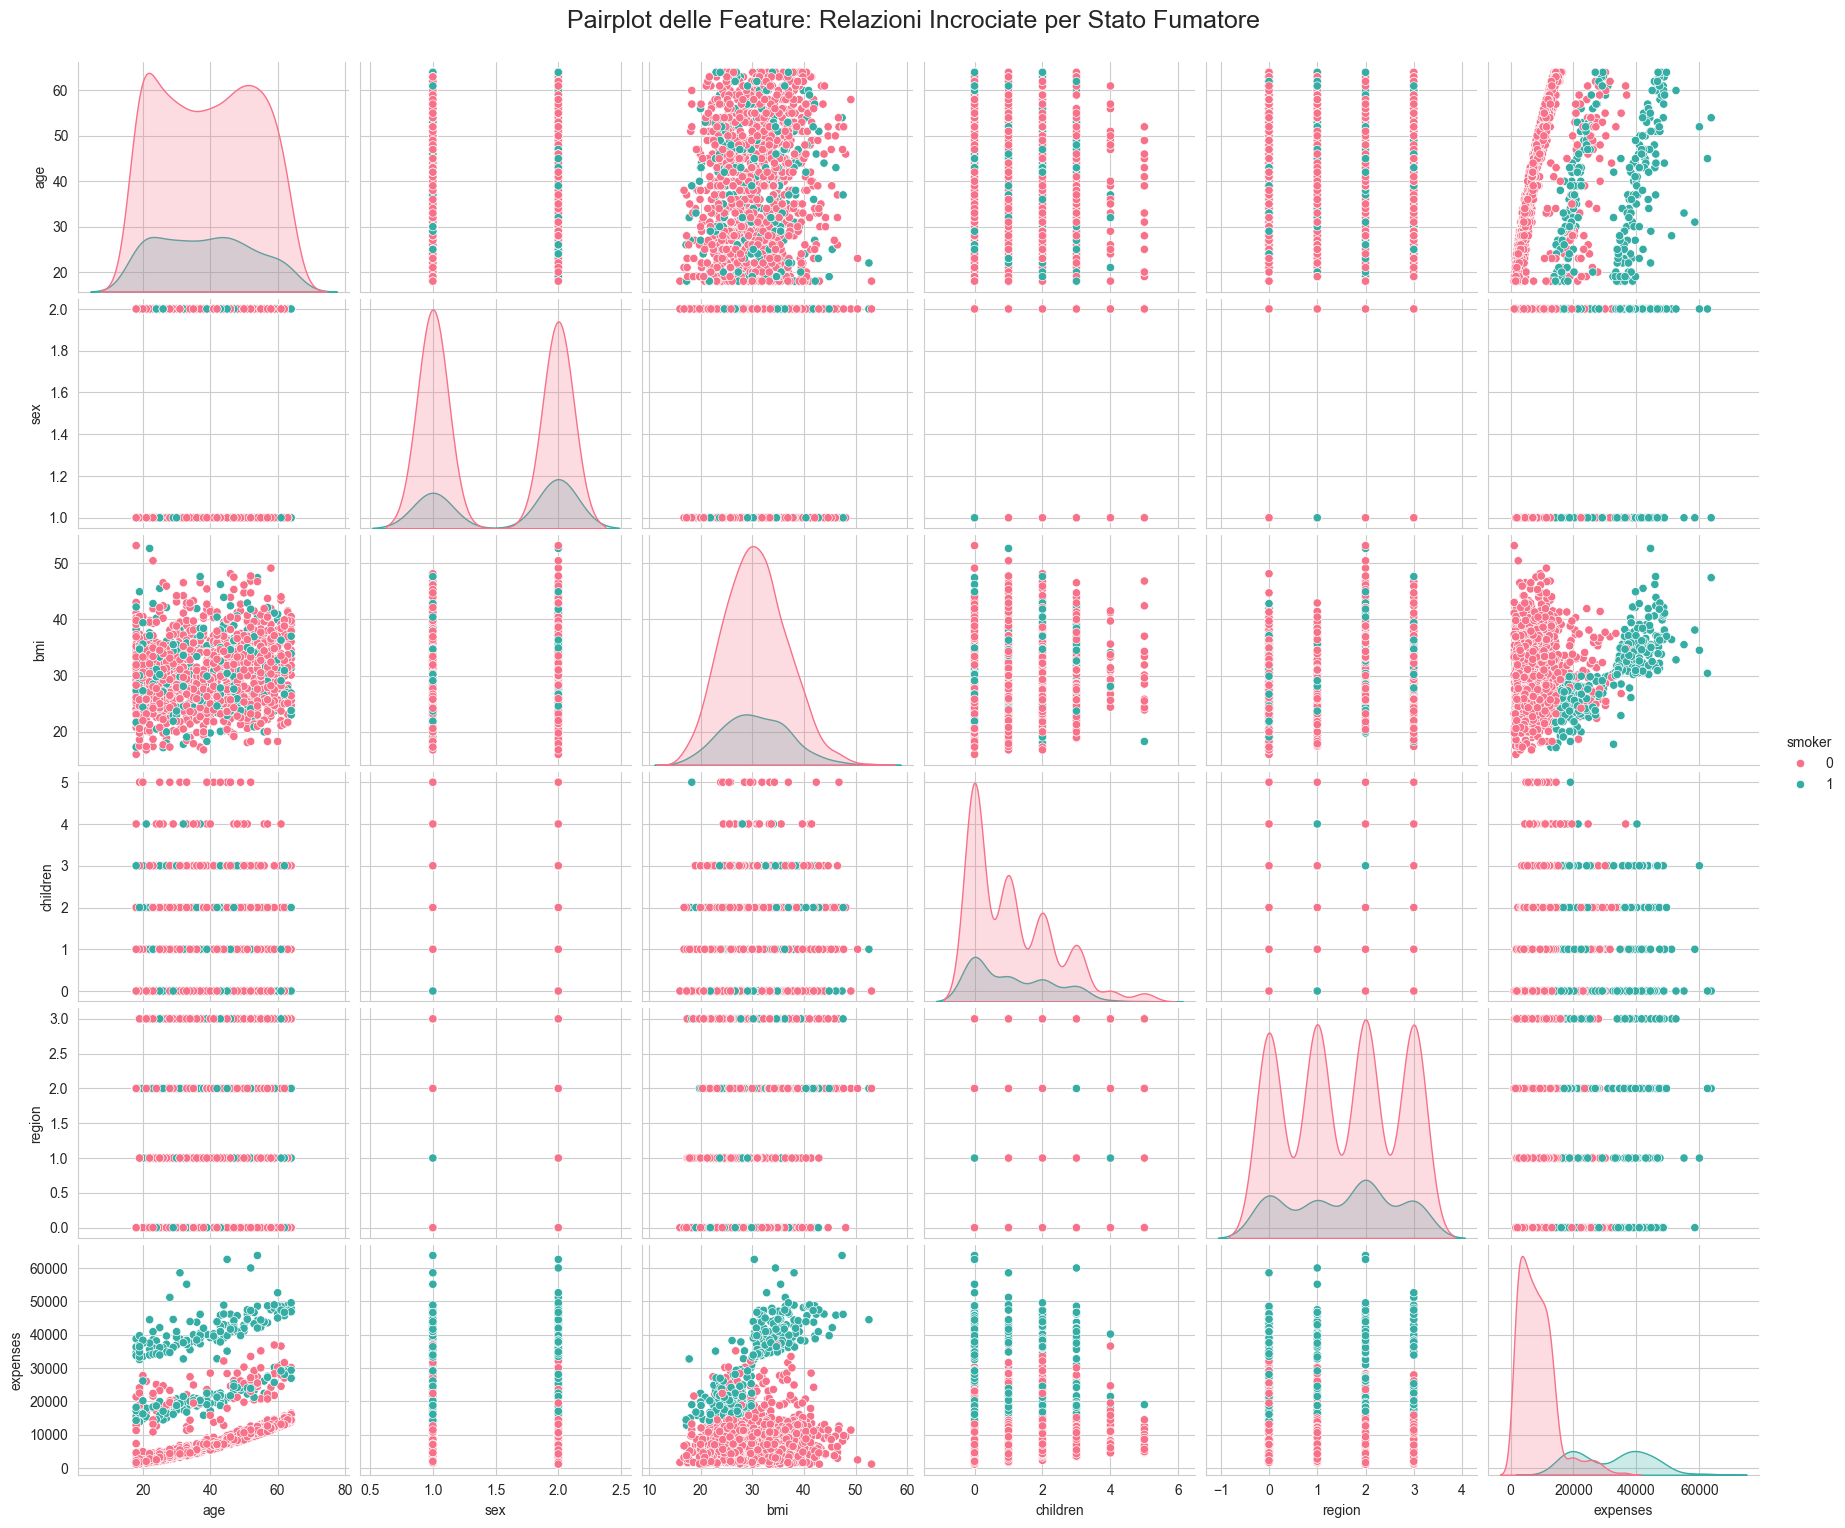

In [118]:
# Analisi di coppia focalizzata sulle variabili numeriche e il fumo
sns.pairplot(dataset, hue='smoker', height=2.5, aspect=1.2, diag_kind='kde', palette='husl')
plt.suptitle('Pairplot delle Feature: Relazioni Incrociate per Stato Fumatore', y=1.02, fontsize=18)
plt.show()

<Figure size 1200x600 with 0 Axes>

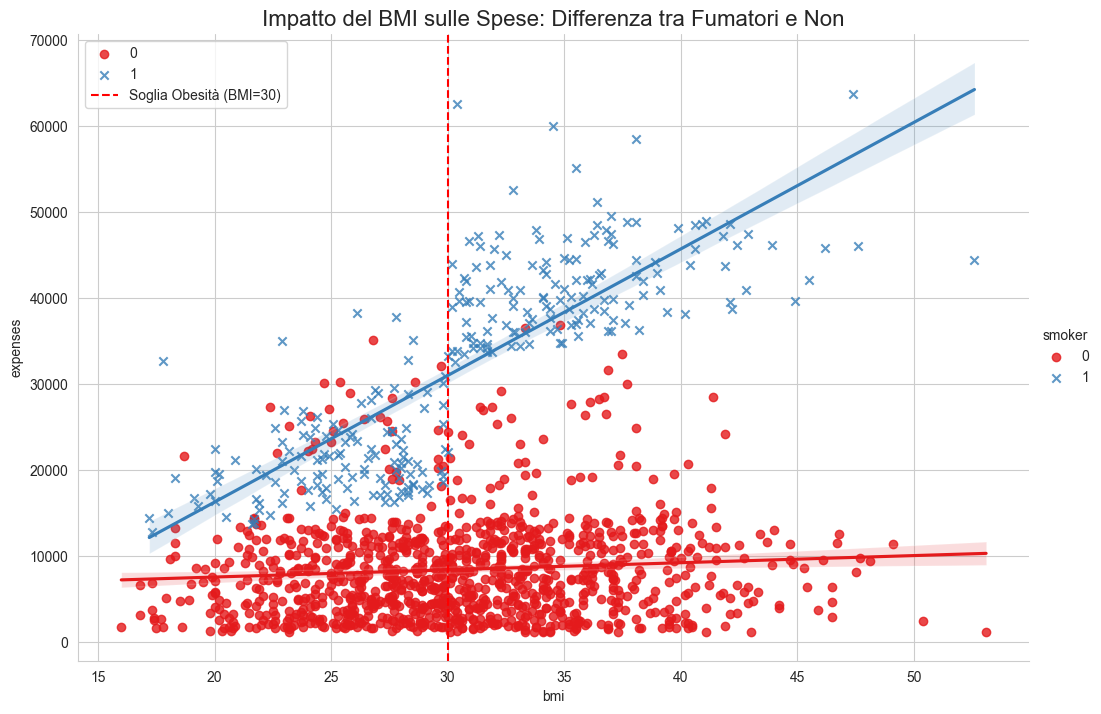

In [119]:
plt.figure(figsize=(12, 6))
sns.lmplot(x='bmi', y='expenses', hue='smoker', data=dataset, 
           markers=["o", "x"], palette="Set1", height=7, aspect=1.5)
plt.axvline(x=30, color='red', linestyle='--', label='Soglia Obesità (BMI=30)')
plt.title('Impatto del BMI sulle Spese: Differenza tra Fumatori e Non', fontsize=16)
plt.legend()
plt.show()

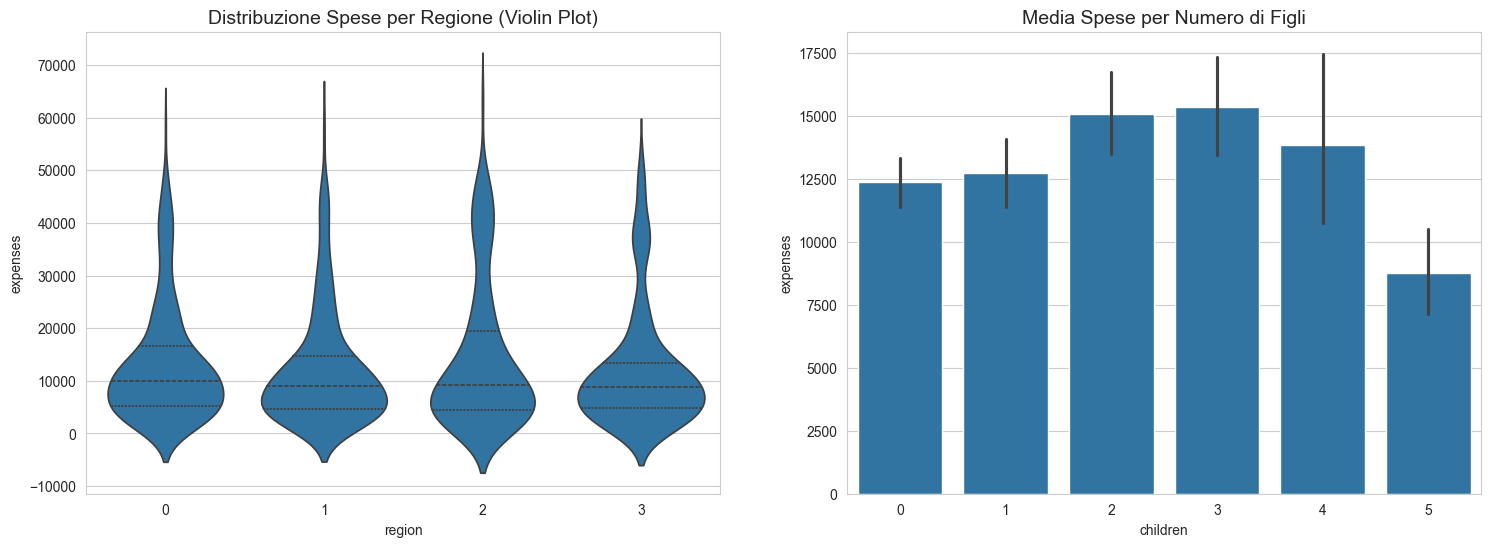

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot Violino per vedere densità e outlier
sns.violinplot(x='region', y='expenses', data=dataset, ax=ax[0], inner="quart")
ax[0].set_title('Distribuzione Spese per Regione (Violin Plot)', fontsize=14)

# Impatto del numero di figli
sns.barplot(x='children', y='expenses', data=dataset, ax=ax[1], estimator=np.mean)
ax[1].set_title('Media Spese per Numero di Figli', fontsize=14)

plt.show()

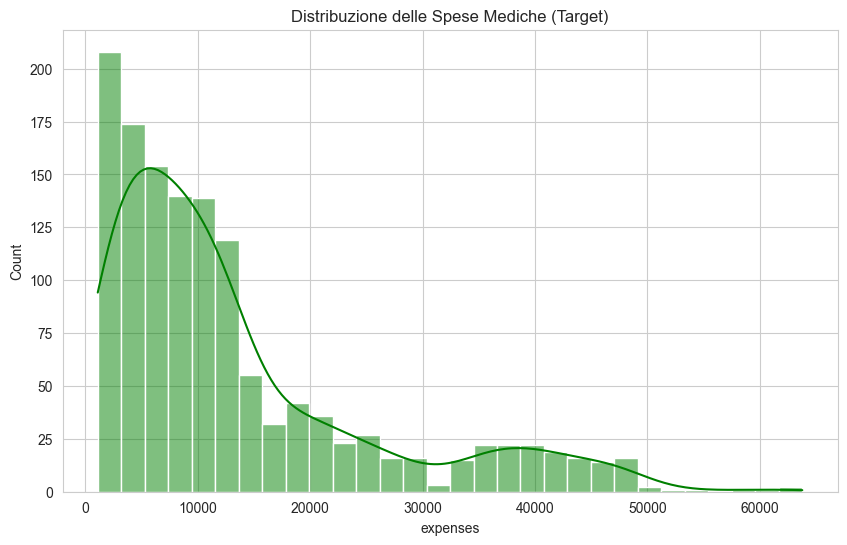

In [121]:
# Impostiamo lo stile
sns.set_style("whitegrid")

# 1. Analisi del Target: 'expenses'
plt.figure(figsize=(10, 6))
sns.histplot(dataset['expenses'], kde=True, color='green')
plt.title('Distribuzione delle Spese Mediche (Target)')
plt.show()

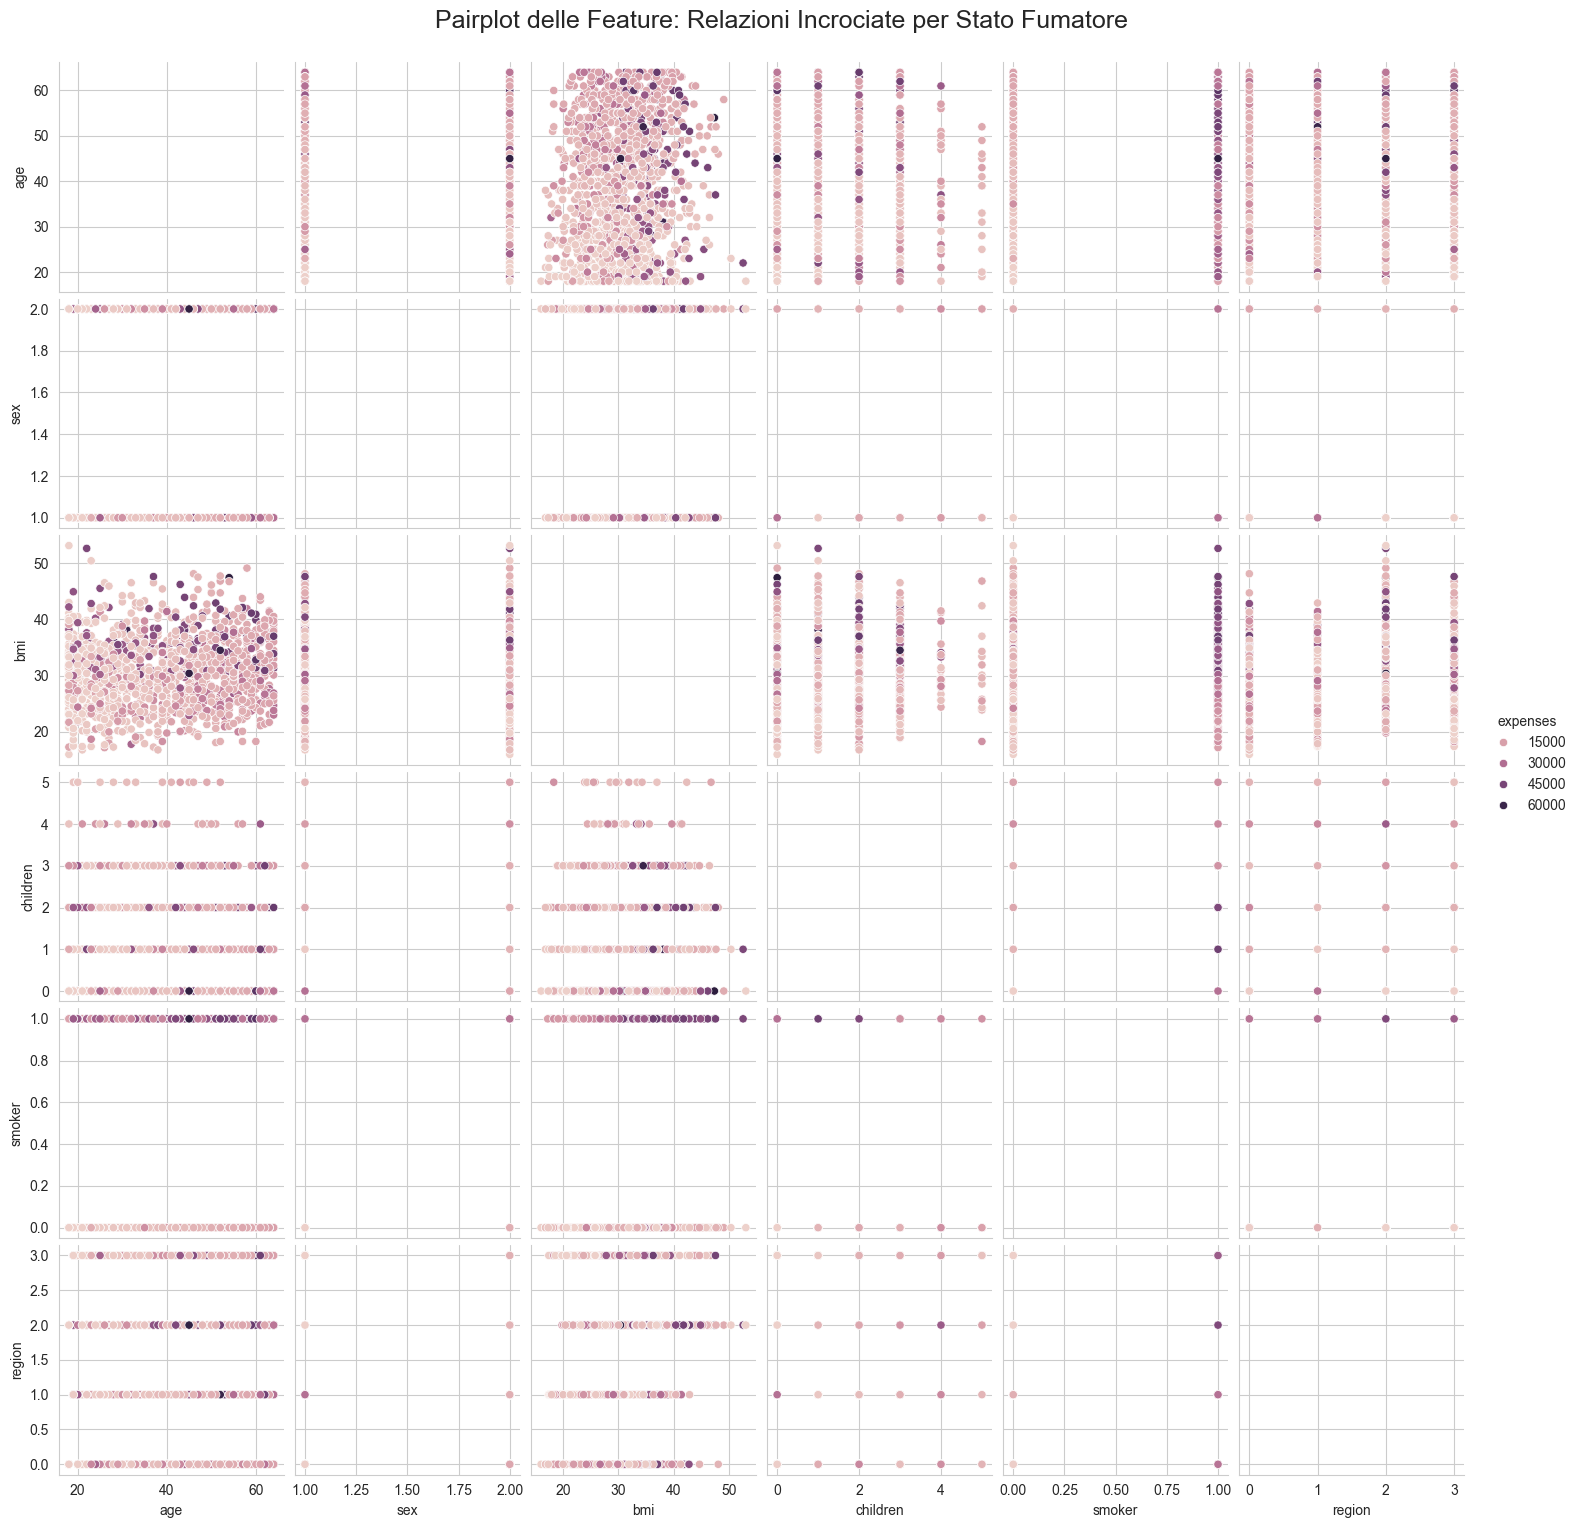

In [122]:
# Analisi di coppia focalizzata sulle variabili numeriche e il fumo
sns.pairplot(data=dataset, hue='expenses')
plt.suptitle('Pairplot delle Feature: Relazioni Incrociate per Stato Fumatore', y=1.02, fontsize=18)
plt.show()

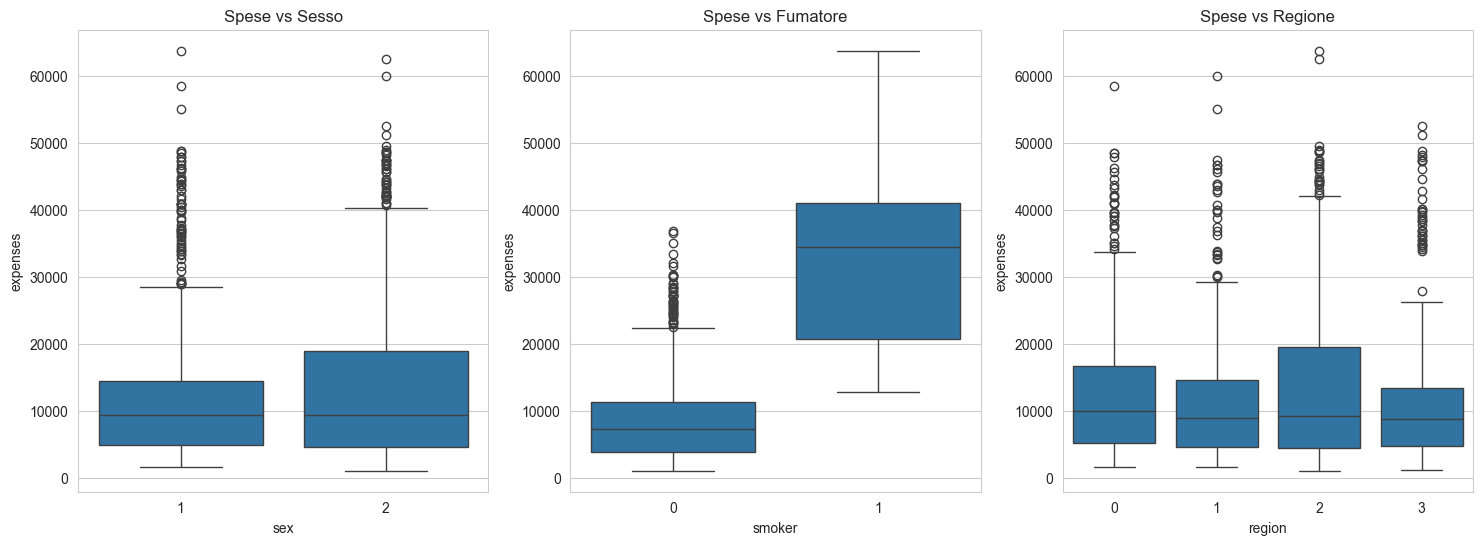

In [123]:
# 1. Categoriche vs Spese (Boxplots)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='sex', y='expenses', data=dataset, ax=ax[0])
ax[0].set_title('Spese vs Sesso')

sns.boxplot(x='smoker', y='expenses', data=dataset, ax=ax[1])
ax[1].set_title('Spese vs Fumatore') # <--- FONDAMENTALE

sns.boxplot(x='region', y='expenses', data=dataset, ax=ax[2])
ax[2].set_title('Spese vs Regione')
plt.show()

In [124]:

dataset = pd.get_dummies(dataset, columns=['region'], prefix='', prefix_sep='')

In [ ]:
# Convert 'region' column to numerical values using One-Hot Encoding

# 3. Split the data into train and test datasets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 4. Pop off the "expenses" column to create labels
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

# 5. Create the model
# Use a Normalization layer to handle different scales of input features
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))

model = keras.Sequential([
    normalizer,
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # Output layer for regression (single value)
])

# 6. Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mae',
              metrics=['mae', 'mse'])

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=6, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=0.00001,
    verbose=1
)

# Training
history = model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    batch_size=32,
    epochs=100, 
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12303.8672 - mae: 12303.8672 - mse: 292596064.0000 - val_loss: 12147.4043 - val_mae: 12147.4043 - val_mse: 299638176.0000 - learning_rate: 0.0100
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7537.4131 - mae: 7537.4131 - mse: 140874592.0000 - val_loss: 5498.9556 - val_mae: 5498.9556 - val_mse: 100647928.0000 - learning_rate: 0.0100
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3665.0957 - mae: 3665.0957 - mse: 48653732.0000 - val_loss: 3639.3821 - val_mae: 3639.3821 - val_mse: 41267136.0000 - learning_rate: 0.0100
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3074.2749 - mae: 3074.2749 - mse: 37758164.0000 - val_loss: 3272.3604 - val_mae: 3272.3604 - val_mse: 41017232.0000 - learning_rate: 0.0100
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2826.0376 - mae: 2826.0376 - mse: 33400432.0000 - val_loss: 3110.4756 - val_mae: 3110.4756 - val_mse: 37843488.0000 - learning_rate: 0.01

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


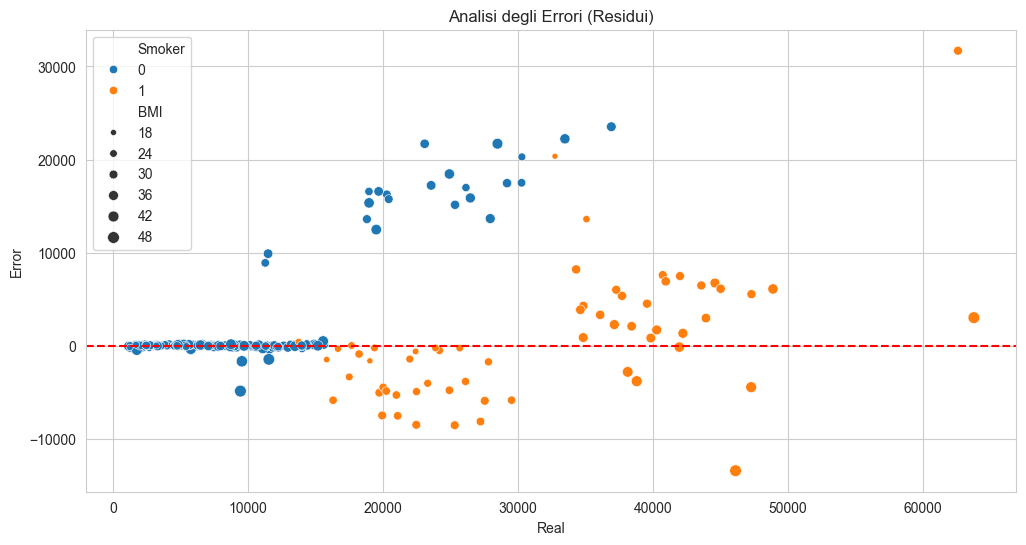

In [132]:
# Calcoliamo le predizioni sul test set
test_predictions = model.predict(test_dataset).flatten()
# Calcoliamo l'errore (Residuo)
residuals = test_labels - test_predictions

# Creiamo un DataFrame temporaneo per l'analisi
error_analysis = pd.DataFrame({
    'Real': test_labels,
    'Predicted': test_predictions,
    'Error': residuals,
    'Smoker': test_dataset['smoker'],
    'BMI': test_dataset['bmi'],
    'Age': test_dataset['age']
})

# Visualizziamo la distribuzione dell'errore rispetto alle variabili
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Real', y='Error', hue='Smoker', size='BMI', data=error_analysis)
plt.axhline(0, color='red', linestyle='--')
plt.title('Analisi degli Errori (Residui)')
plt.show()

9/9 - 0s - 2ms/step - loss: 2578.9504 - mae: 2578.9504 - mse: 35401976.0000
Testing set Mean Abs Error: 2578.95 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


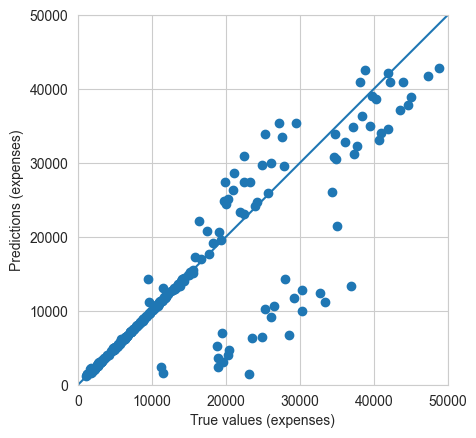

In [133]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
